In [3]:
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.signal import argrelextrema
from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import folium 
from folium.plugins import StripePattern
import branca.colormap
from collections import defaultdict
from folium.plugins import HeatMap

In [4]:
df = pd.read_csv("clean_saas.csv")

In [8]:
print(df.describe()) 

       Customer ID         Sales     Quantity     Discount       Profit  \
count  9993.000000   9993.000000  9993.000000  9993.000000  9993.000000   
mean   1049.773742    229.852846     3.789753     0.156188    28.660971   
std      29.720343    623.276074     2.225149     0.206457   234.271476   
min    1001.000000      0.444000     1.000000     0.000000 -6599.978000   
25%    1024.000000     17.280000     2.000000     0.000000     1.731000   
50%    1049.000000     54.480000     3.000000     0.200000     8.671000   
75%    1076.000000    209.940000     5.000000     0.200000    29.364000   
max    1101.000000  22638.480000    14.000000     0.800000  8399.976000   

       Profit Margin  
count    9993.000000  
mean        0.120330  
std         0.466775  
min        -2.750000  
25%         0.075000  
50%         0.270000  
75%         0.362500  
max         0.500000  


# Analisis Deskriptif

In [9]:
# Load your dataset
df = pd.read_csv("clean_saas.csv")

# Select numeric columns relevant to discount analysis
cols = ["Sales", "Quantity", "Discount", "Profit"]
real_data = df[cols].copy()

# Step 1: Basic descriptive statistics
descriptive_stats_real = real_data.describe().T

# Step 2: Add skewness and kurtosis
descriptive_stats_real["Skewness"] = real_data.skew()
descriptive_stats_real["Kurtosis"] = real_data.kurtosis()

# Step 3: Calculate IQR for outlier detection
Q1 = real_data.quantile(0.25)
Q3 = real_data.quantile(0.75)
IQR = Q3 - Q1

# Step 4: Identify and count outliers based on 1.5 * IQR rule
outliers = ((real_data < (Q1 - 1.5 * IQR)) | (real_data > (Q3 + 1.5 * IQR))).sum()
descriptive_stats_real["Outliers"] = outliers

# Show final table
print(descriptive_stats_real)

           count        mean         std       min     25%     50%      75%  \
Sales     9993.0  229.852846  623.276074     0.444  17.280  54.480  209.940   
Quantity  9993.0    3.789753    2.225149     1.000   2.000   3.000    5.000   
Discount  9993.0    0.156188    0.206457     0.000   0.000   0.200    0.200   
Profit    9993.0   28.660971  234.271476 -6599.978   1.731   8.671   29.364   

                max   Skewness    Kurtosis  Outliers  
Sales     22638.480  12.972142  305.281770      1167  
Quantity     14.000   1.278416    1.991583       170  
Discount      0.800   1.684508    2.409977       856  
Profit     8399.976   7.561036  397.150385      1881  


## Implikasi Analisis Deskriptif

Implikasi Utama

1. Skewness ekstrim dan Heavy Tails
    Baik Sales maupun Profit menunjukkan kemiringan (skewness) dan kurtosis yang sangat tinggi, yang mengimplikasikan:
    mengindikasikan distribusi non-normal dengan mayoritas transaksi kecil, tetapi juga sejumlah kecil transaksi besar.
    Outlier ini mendominasi rata-rata - **mengandalkan rata-rata saja dapat menghasilkan kesimpulan yang menyesatkan**.
    Analisis profitabilitas harus mempertimbangkan median dan rata-rata yang dipangkas atau agregasi berbasis segmen.

2. Penggunaan Diskon Tinggi dengan Ekor Panjang
    Sebagian besar diskon mengelompok di sekitar 0-20%, tetapi ada juga yang mencapai 80%.
    Hal ini menunjukkan bahwa bisnis tersebut **menggunakan diskon besar-besaran dalam kasus-kasus tertentu**, mungkin tanpa kontrol yang ketat.
    Transaksi dengan diskon tinggi ini mungkin tidak selalu menghasilkan keuntungan yang cukup - **harus diaudit**.

3. Variabilitas Laba yang Sangat Besar
    Laba berkisar antara -6.599 hingga +8.399, dengan standar deviasi yang tinggi.
    Tingkat fluktuasi ini menunjukkan:

    Beberapa transaksi **mungkin sengaja tidak menguntungkan (loss leader)**.

    Yang lainnya adalah kemenangan dengan margin tinggi - dapat mengindikasikan peluang untuk meniru pola penetapan harga yang sukses.

4. Outlier bukan kasus langka dalam dataset ini — mereka mewakili pola transaksi tertentu, bukan hanya "noise statistik".

    Implikasi:
    Setiap model prediksi atau optimasi harus kuat terhadap outlier.
    **Keputusan kebijakan tidak boleh berbasis rata-rata saja**.

5. Diskon Kemungkinan Mendorong Volume tetapi Tidak Selalu Menghasilkan Keuntungan
    Meskipun analisis korelasi yang lebih dalam belum dilakukan, frekuensi outlier yang tinggi pada Profit dan Diskon mengisyaratkan hal ini:

    Diskon besar mungkin meningkatkan volume tapi tidak selalu meningkatkan profit. Harus **identifikasi di mana kurva diskon-laba melengkung** - yaitu, titik diskon di mana laba mulai menurun.

6. Satu Ukuran Tidak Cocok untuk Semua
    Karena keragaman dalam Kuantitas, Penjualan, dan Laba, **strategi harus disesuaikan per segmentasi**:

    Klien SMB vs Klien Strategic (segment), atau berdasarkan Produk atau Wilayah.

    Perlakukan klien bervolume tinggi/diskon tinggi secara berbeda dari klien dengan margin kecil.

# Visualisasi 


## Sales, Profit, Discount, Profit Margin Distribution

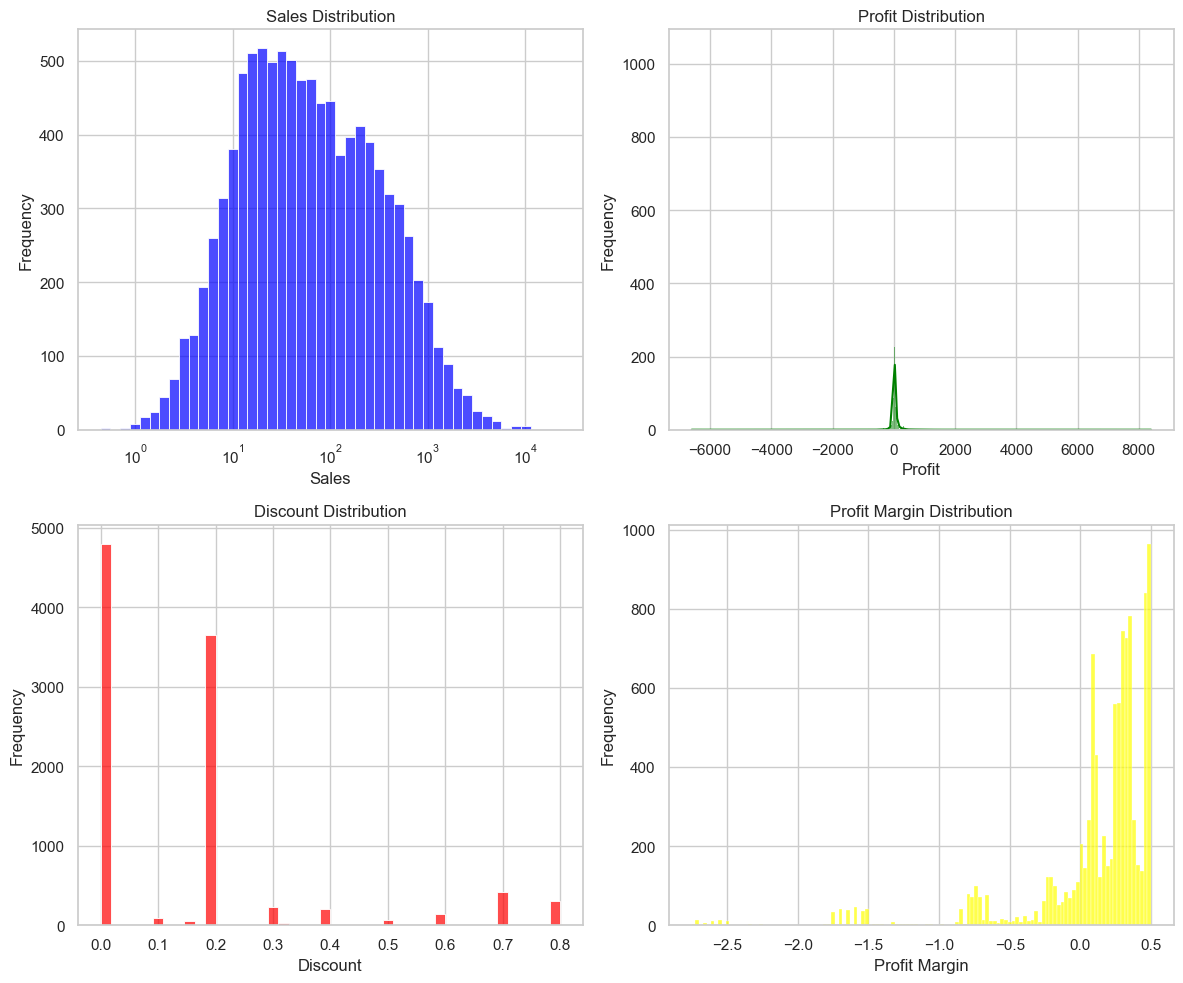

In [10]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Sales Distribution
sns.histplot(df["Sales"], ax=axs[0, 0], color="blue", alpha=0.7, log_scale=True)

axs[0, 0].set_title('Sales Distribution')
axs[0, 0].set_xlabel('Sales')
axs[0, 0].set_ylabel('Frequency')

# Profit Distribution
sns.histplot(df["Profit"], ax=axs[0, 1], color="green", kde=True)
axs[0, 1].set_title('Profit Distribution')
axs[0, 1].set_xlabel('Profit')
axs[0, 1].set_ylabel('Frequency')

# Discount Distribution
sns.histplot(df["Discount"], ax=axs[1, 0], color="red", alpha=0.7)
axs[1, 0].set_title('Discount Distribution')
axs[1, 0].set_xlabel('Discount')
axs[1, 0].set_ylabel('Frequency')

# Profit Margin Distribution
sns.histplot(df["Profit Margin"], ax=axs[1, 1], color="yellow", alpha=0.7)
axs[1, 1].set_title('Profit Margin Distribution')
axs[1, 1].set_xlabel('Profit Margin')
axs[1, 1].set_ylabel('Frequency')

# Layout
plt.tight_layout()
plt.show()

Visualisasi ini mengungkap pola distribusi utama yang menjadi dasar penting untuk menyusun strategi diskon dan optimalisasi profitabilitas.

🔹 Distribusi Penjualan
Menunjukkan **kemiringan kanan yang tajam** pada skala logaritmik.

Mayoritas transaksi bernilai kecil, namun sejumlah kecil transaksi besar mendominasi total pendapatan.

Transaksi besar ini kemungkinan berasal dari akun strategic atau pelanggan enterprise, yang perlu dikelola secara khusus dalam strategi harga.

🔹 Distribusi Laba
Terkonsentrasi di sekitar nol, dengan ekor memanjang ke arah negatif maupun positif.

Mengindikasikan **margin keuntungan rata-rata yang tipis** serta keberadaan transaksi yang berlaba tinggi maupun merugi besar — mencerminkan ketidakkonsistenan dalam struktur harga atau biaya.

🔹 Distribusi Diskon
Bersifat multi-modal dengan lonjakan jelas pada tingkat diskon 0%, 20%, 40%, dan 60%.

Menunjukkan adanya pola **diskon bertingkat yang tidak kontinu**, kemungkinan berasal dari kebiasaan pemberian diskon yang tidak berbasis data atau tidak terstandarisasi.

🔹 Distribusi Margin Laba
Memiliki dispersi yang luas, termasuk margin negatif dalam jumlah signifikan.

Meski sebagian besar transaksi berada pada kisaran margin 10–30%, banyak juga transaksi dengan kerugian finansial, terutama pada klien berdiskon tinggi atau volume rendah.


## Heatmap Correlation Matrix (Sales, Quantity, Discount, Profit, Profit Margin)


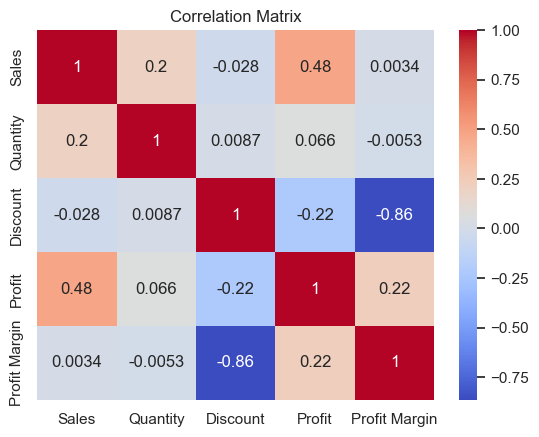

In [12]:
# Drop Customer ID (and any other irrelevant columns)
cols_to_use = ["Sales", "Quantity", "Discount", "Profit", "Profit Margin"]  # Include engineered features too
corr_matrix = df[cols_to_use].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## Correlation Matrix

Heatmap ini menunjukkan hubungan dinatar ke-lima variabel: **Sales**, **Quantity**, **Discount**, **Profit**, and **Profit Margin**.

🔸 Sales vs Quantity (0.20)	Korelasi **positif lemah** – penjualan meningkat saat jumlah naik, tapi **tidak proporsional** (kemungkinan pengaruh diskon atau variasi harga satuan).

🔸 Discount vs Profit Margin (-0.86) **Sangat negatif** – **diskon besar secara konsisten menggerus margin laba**. Korelasi ini mendukung perlunya kebijakan diskon berbasis margin minimum.

🔸 Discount vs Profit (-0.22) **negatif moderat** – diskon tinggi cenderung menurunkan profit, meski **dampaknya tidak sekuat terhadap margin**.

🔸 Sales vs Profit (0.48) **positif sedang** – penjualan tinggi cenderung menghasilkan laba tinggi, namun masih bisa terdistorsi oleh diskon atau biaya.

🔸 Quantity vs Profit (0.066)	**sangat lemah** – volume tinggi tidak menjamin profit, menunjukkan **potensi ketidakefisienan harga atau biaya**.

🔸 Profit vs Profit Margin (0.22) **lemah–sedang** – transaksi dengan laba tinggi belum tentu memiliki margin tinggi (bisa karena volume besar tapi harga tipis).

## Discount Vs Profit Scatterplot By Segment

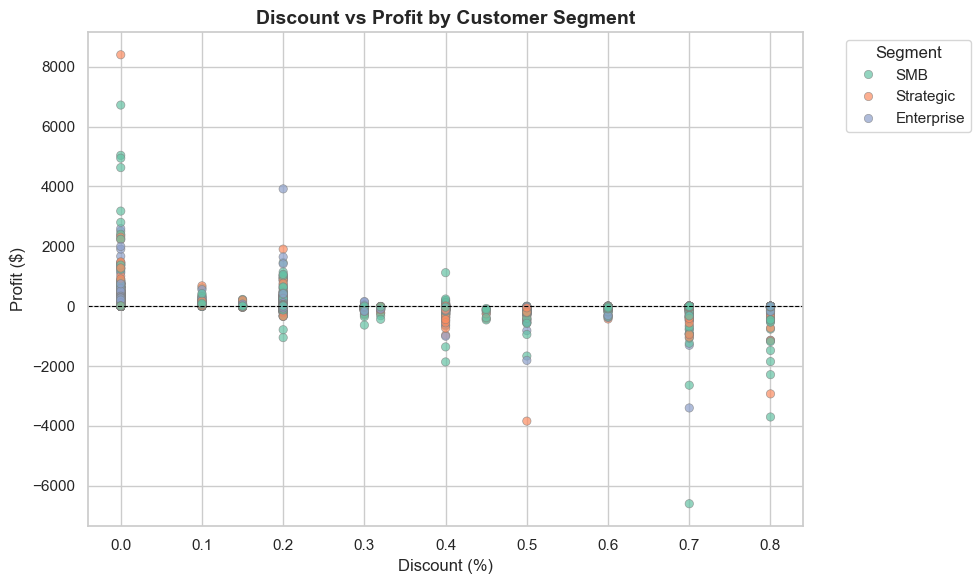

In [11]:
# Set up the plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create scatterplot colored by Segment
scatter = sns.scatterplot(
    data=df,
    x='Discount',
    y='Profit',
    hue='Segment',
    palette='Set2',
    alpha=0.7,
    edgecolor='gray',
    linewidth=0.5
)

# Add title and axis labels
plt.title("Discount vs Profit by Customer Segment", fontsize=14, weight='bold')
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Profit ($)", fontsize=12)

# Add horizontal reference line at profit = 0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Position the legend outside the plot
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

# Clean layout
plt.tight_layout()
plt.show()


### Discount vs Profit by Customer Segment
SMB sensitif terhadap diskon, hasil laba luas, banyak merugi. Diskon >30% tampak paling berisiko untuk SMB

Strategic	stabil, menyebar seimbang. Indikasi segmentasi berbasis relasi dan CLV

Enterprise disiplin harga, profit tinggi.	Outlier sedikit, kemungkinan karena volume-based margin

## Median Profit by Discount Level and Segment

C:\Users\asus\AppData\Local\Temp\ipykernel_14432\1221536438.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(['Discount_Bucket', 'Segment'])['Profit'].median().reset_index()


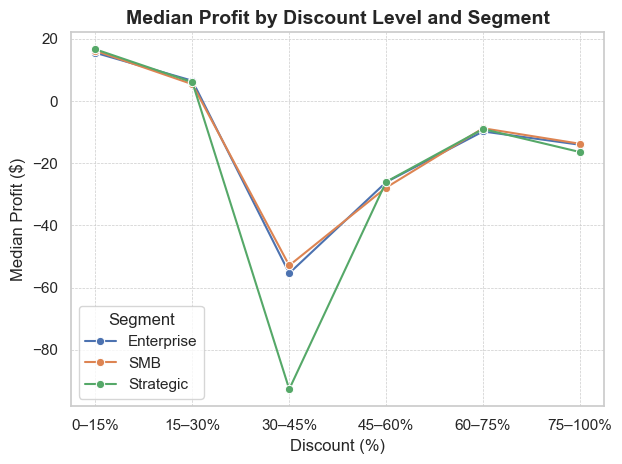

In [ ]:
# Group by Discount and Segment to calculate median profit
df_grouped = df.groupby(['Discount_Bucket', 'Segment'])['Profit'].median().reset_index()

# Set the plot style
sns.set_style("whitegrid")

# Create the lineplot
sns.lineplot(
    data=df_grouped,
    x='Discount_Bucket',
    y='Profit',
    hue='Segment',
    marker='o'
)

# Formatting the plot
plt.title("Median Profit by Discount Level and Segment", fontsize=14, weight='bold')
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Median Profit ($)", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(title='Segment')
plt.tight_layout()
plt.show()


Temuan Utama (Berdasarkan Median Profit):
Tren Penurunan Umum
Di semua segmen, laba median menurun secara konsisten seiring meningkatnya tingkat diskon — penurunan paling signifikan dimulai setelah 30%, mengindikasikan titik tipping point profitabilitas.

Segmen SMB
Mengalami penurunan median profit tercepat dan memasuki zona negatif sejak diskon 30–45%. Menunjukkan kerentanan tinggi terhadap diskon, dan perlu batasan diskon ketat.

Segmen Strategic
Memiliki kurva paling tajam dan fluktuatif, dengan penurunan ekstrem pada 30–45%, tapi ada pemulihan di tingkat diskon berikutnya. Hal ini bisa mencerminkan diskon yang terlalu bervariasi antar klien.

Segmen Enterprise
Menunjukkan daya tahan yang lebih baik terhadap diskon tinggi. Meskipun median tetap menurun, penurunannya lebih terkontrol, menunjukkan potensi efisiensi volume atau negosiasi yang lebih terstruktur.

Anomali Diskon Tinggi (60–75%)
Terlihat pemulihan median profit meskipun diskon sangat tinggi. Hal ini kemungkinan dipengaruhi oleh:

-Transaksi volume besar yang tetap untung

-Deal renewal/update strategis

-Struktur biaya rendah untuk produk tertentu

Kesimpulan:
Tetapkan threshold diskon berbasis segmen:

SMB: Maksimal 30%

Strategic: Validasi wajib >30%

Enterprise: Fleksibel tapi tetap diawasi

Transaksi diskon 60%+ harus dianggap “strategic deals” dan dievaluasi ROI-nya secara jangka panjang.

## Discount, Deal Size, and Regional Profitability

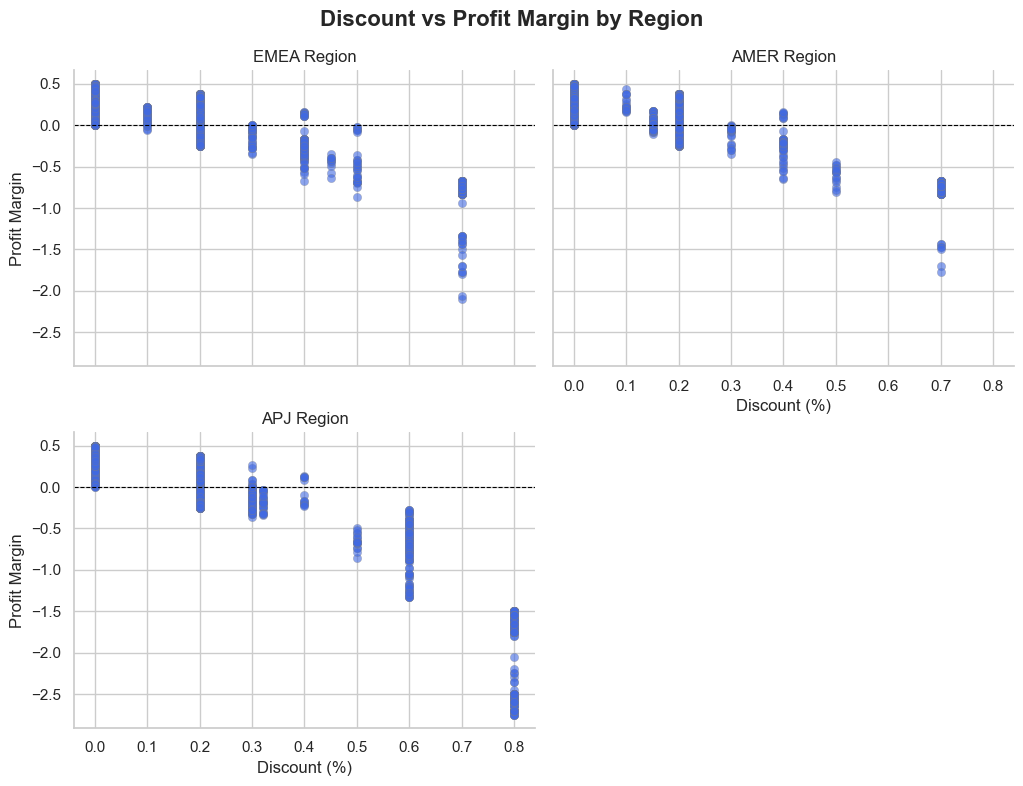

In [14]:
sns.set_style("whitegrid")

g = sns.FacetGrid(
    df, 
    col="Region", 
    col_wrap=2, 
    height=4, 
    aspect=1.3
)

g.map_dataframe(
    sns.scatterplot,
    x="Discount",
    y="Profit Margin",
    alpha=0.6,
    color="royalblue",
    edgecolor="gray",
    linewidth=0.3
)

g.set_axis_labels("Discount (%)", "Profit Margin")
g.set_titles(col_template="{col_name} Region")

for ax in g.axes.flat:
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8)


plt.subplots_adjust(top=0.9)
g.fig.suptitle("Discount vs Profit Margin by Region", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

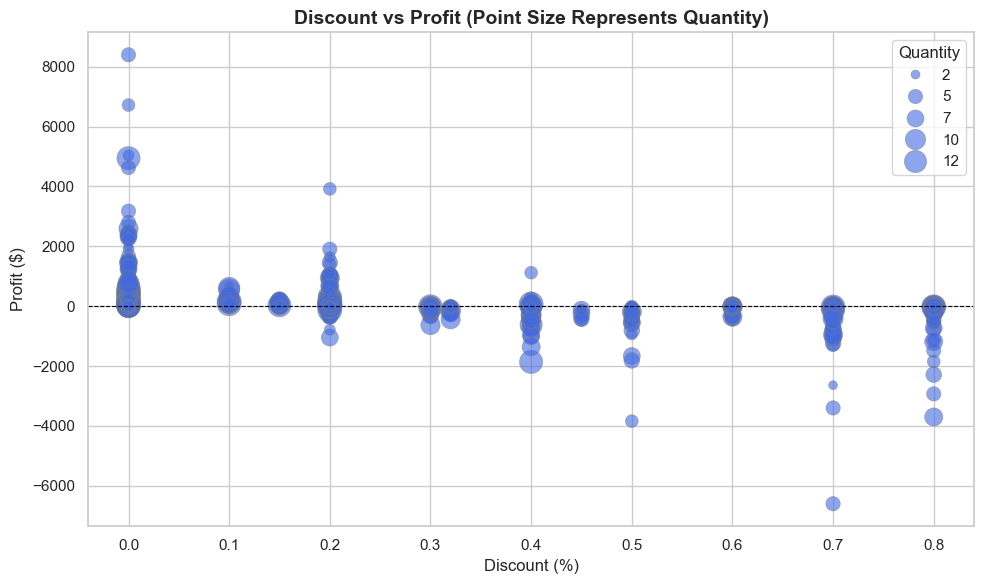

In [15]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="Discount",
    y="Profit",
    size="Quantity",
    sizes=(20, 300),  
    alpha=0.6,
    color="royalblue",
    edgecolor="gray",
    linewidth=0.5
)

plt.title("Discount vs Profit (Point Size Represents Quantity)", fontsize=14, weight='bold')
plt.xlabel("Discount (%)", fontsize=12)
plt.ylabel("Profit ($)", fontsize=12)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

##  Discount, Deal Size, and Regional Profitability

---

### Temuan Utama:
- **AMER** menunjukkan **varians diskon yang tinggi** dengan lebih banyak transaksi margin negatif, yang menunjukkan **kendali harga yang lebih longgar**.
- **EMEA** menunjukkan **konsistensi yang lebih baik** — diskonnya sedang, dan margin umumnya stabil.
- **APJ** menunjukkan **polarisasi**: beberapa transaksi dengan **diskon yang sangat tinggi dan kerugian margin yang tajam**, sementara yang lain tetap efisien.
- **Transaksi dalam jumlah besar** (lingkaran besar) sering kali menerima diskon yang lebih tinggi — tetapi tidak selalu menguntungkan.
- Beberapa transaksi **diskon besar, volume tinggi** menunjukkan **laba negatif atau sangat tipis**, yang memperlihatkan risiko dalam penetapan harga berdasarkan volume.
- Banyak **transaksi dalam jumlah kecil** mengelompok di sekitar diskon sedang, tetapi dengan profitabilitas yang sangat bervariasi.

---

### Kesimpulan:

- Terapkan **Treshold diskon khusus Region**: AMER dan APJ menunjukkan volatilitas harga yang lebih besar; EMEA dapat menjadi tolok ukur.
- Review **transaksi dengan Quantity tinggi dan Margin rendah** untuk potensi negosiasi ulang harga atau bundling.
- Buat **kriteria penilaian transaksi** yang mempertimbangkan: 
1. Tingkat diskon 
2. Quatity yang diharapkan 
3. Region pelanggan 
4. Margin laba yang aman

## Tipping Point: Discount % vs. Median Profit Margin

C:\Users\asus\AppData\Local\Temp\ipykernel_14432\4051739354.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_bucket = df.groupby('Discount_Bucket')['Profit Margin'].median().reset_index()


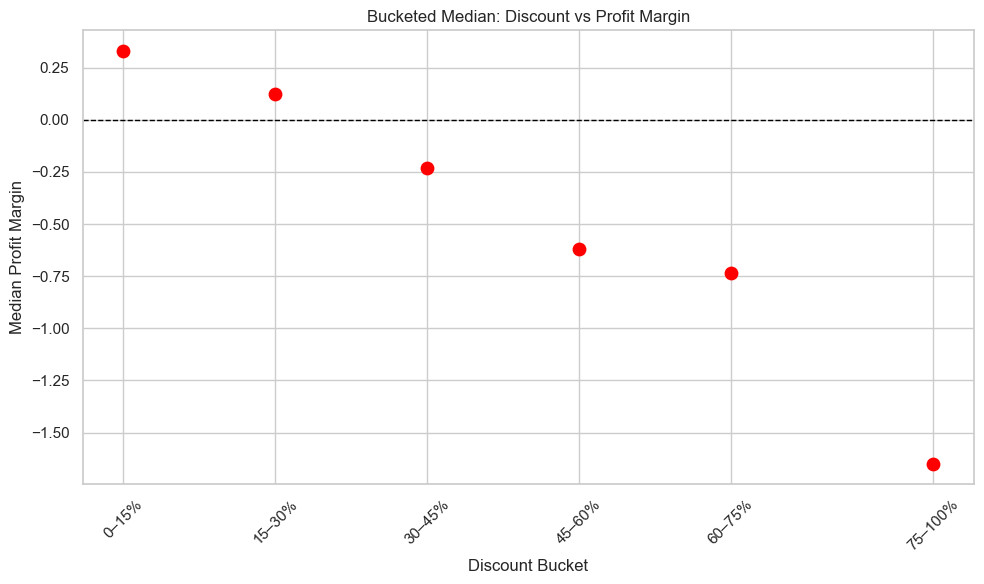

In [30]:
# Pastikan Discount dalam skala 0–1 
if df['Discount'].max() > 1:
    df['Discount'] = df['Discount'] / 100

#  Buat Discount Bucket
discount_bins = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1.0]
discount_labels = ["0–15%", "15–30%", "30–45%", "45–60%", "60–75%", "75–100%"]
df['Discount_Bucket'] = pd.cut(
    df['Discount'],
    bins=discount_bins,
    labels=discount_labels,
    include_lowest=True
)

# Hitung median profit margin per bucket
df_bucket = df.groupby('Discount_Bucket')['Profit Margin'].median().reset_index()

# Buat titik tengah bucket untuk plotting X axis ---
bucket_midpoints = [0.075, 0.225, 0.375, 0.525, 0.675, 0.875]
df_bucket['Bucket Midpoint'] = bucket_midpoints

# Plot visualisasi Bucketed Median
plt.figure(figsize=(10,6))
plt.scatter(df_bucket['Bucket Midpoint'], df_bucket['Profit Margin'], color='red', s=80)
plt.axhline(0, color='black', linestyle='--', linewidth=1)

plt.xticks(df_bucket['Bucket Midpoint'], discount_labels, rotation=45)
plt.xlabel('Discount Bucket')
plt.ylabel('Median Profit Margin')
plt.title('Bucketed Median: Discount vs Profit Margin')
plt.grid(True)
plt.tight_layout()
plt.show()


### Analisis Bucket (Titik Merah):
Menggabungkan tingkat diskon ke dalam interval bisnis yang bermakna (misalnya 0–15%, 15–30%, dst).

Titik kritis konsisten saat margin median bergeser dari positif ke negatif — khususnya dalam bucket diskon 30–45%.

Menawarkan kerangka kerja yang stabil untuk mengembangkan pembatas diskon per kebijakan harga.

Kesimpulan
Tetapkan treshold yang jelas: **Tingkat diskon di atas 30%** secara **konsisten mengubah margin median menjadi negatif**, dan harus memicu peninjauan atau memerlukan pembenaran.

Zona Diskon:

0–15%: Zona aman

15–30%: Zona terkelola (persetujuan mungkin diperlukan)

30%: Zona risiko (hanya strategic, dengan CLTV atau pembenaran kontrak)


## Profit Margin Distribution by Discount Bucket, Segment and Industry

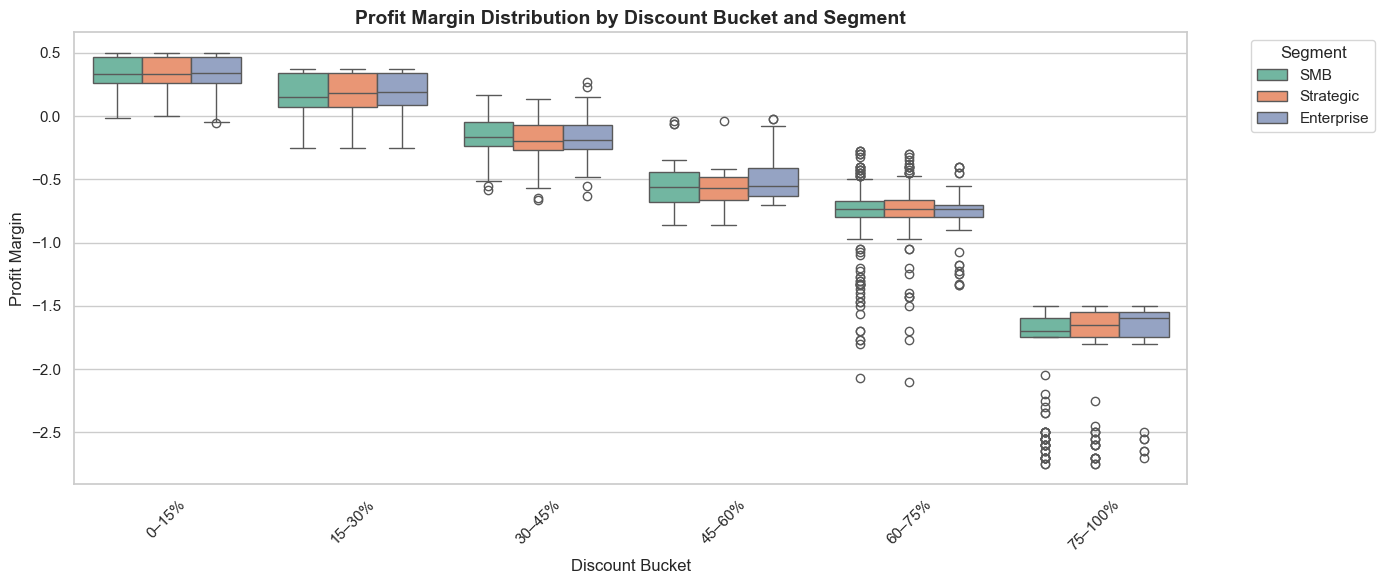

count    300.000000
mean      -1.825000
std        0.400407
min       -2.750000
25%       -1.750000
50%       -1.650000
75%       -1.550000
max       -1.500000
Name: Profit Margin, dtype: float64

In [31]:
# Create discount buckets
if df['Discount'].max() > 1:
    df['Discount'] = df['Discount'] / 100
discount_bins = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1.0]
discount_labels = ["0–15%", "15–30%", "30–45%", "45–60%","60–75%", "75–100%"]
df["Discount Bucket"] = pd.cut(df["Discount"], bins=discount_bins, labels=discount_labels, right=False)

# Plot boxplot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

sns.boxplot(
    data=df,
    x='Discount Bucket',
    y='Profit Margin',
    hue='Segment',
    palette='Set2'
)

# Add plot formatting
plt.title("Profit Margin Distribution by Discount Bucket and Segment", fontsize=14, weight='bold')
plt.xlabel("Discount Bucket", fontsize=12)
plt.ylabel("Profit Margin", fontsize=12)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df[df['Discount Bucket'] == '75–100%']['Profit Margin'].describe()


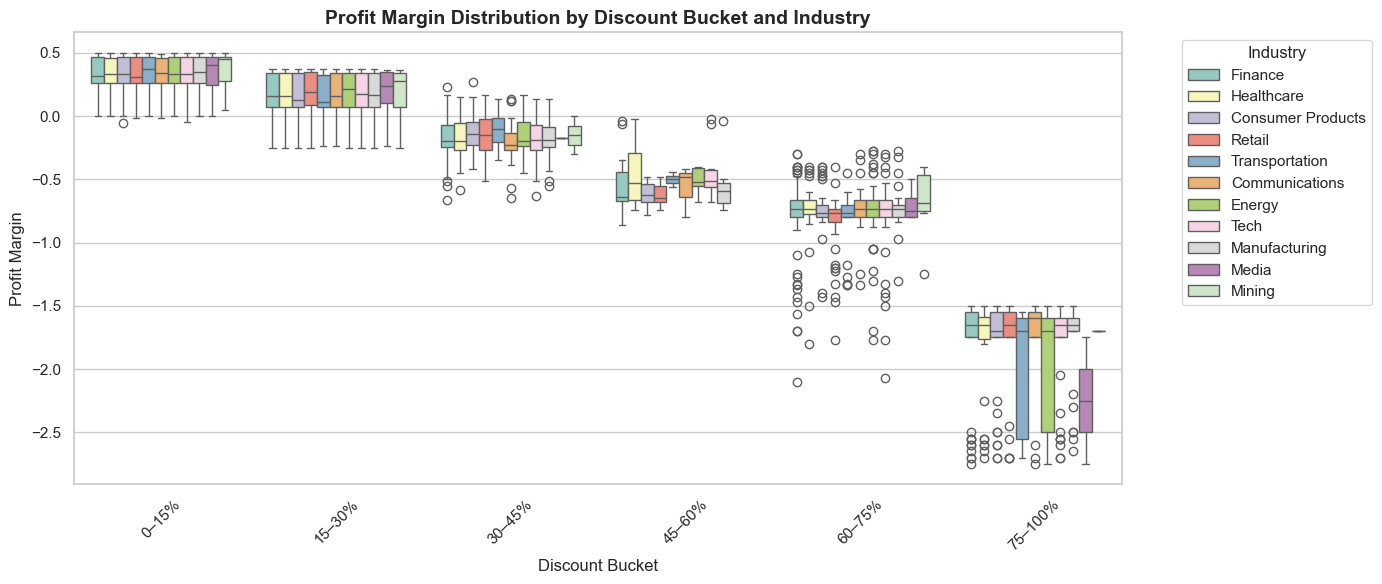

count    300.000000
mean      -1.825000
std        0.400407
min       -2.750000
25%       -1.750000
50%       -1.650000
75%       -1.550000
max       -1.500000
Name: Profit Margin, dtype: float64

In [33]:
# Create discount buckets
discount_bins = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1.0]
discount_labels = ["0–15%", "15–30%", "30–45%", "45–60%", "60–75%", "75–100%"]
df["Discount Bucket"] = pd.cut(df["Discount"], bins=discount_bins, labels=discount_labels, right=False)

# Plot boxplot
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

sns.boxplot(
    data=df,
    x='Discount Bucket',
    y='Profit Margin',
    hue='Industry',
    palette='Set3'
)

# Formatting
plt.title("Profit Margin Distribution by Discount Bucket and Industry", fontsize=14, weight='bold')
plt.xlabel("Discount Bucket", fontsize=12)
plt.ylabel("Profit Margin", fontsize=12)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df[df['Discount Bucket'] == '75–100%']['Profit Margin'].describe()


## Profit Margin Distribution by Discount Bucket — Segment and Industry Insights

#### 🔍 Wawasan Utama:
- **Pelanggan SMB** mengalami **penurunan paling tajam** dalam margin laba seiring dengan kenaikan tingkat diskon — khususnya di atas 30%.
- **Pelanggan Strategic** mempertahankan margin yang lebih stabil hingga 30–45%, yang menunjukkan **kesediaan untuk menukar sebagian margin dengan nilai jangka panjang**.
- **Pelanggan Enterprise** menunjukkan **retensi margin yang relatif kuat**, bahkan dalam kisaran 30–45%, meskipun erosi margin terlihat jelas pada kelompok diskon yang lebih dalam (60%+).

- Beberapa industri (misalnya, **Tech**) menunjukkan **ketahanan terhadap diskon**, dengan banyak transaksi mempertahankan margin yang kuat hingga 30–45%.
- Lainnya (misalnya, **Retail**) mengalami **erosi margin yang cepat**, dengan banyak transaksi pada tingkatan diskon yang lebih tinggi menghasilkan **margin nol atau negatif**. - Industri tertentu menunjukkan **variabilitas margin yang tinggi**, yang menunjukkan ketidakkonsistenan dalam strategi penetapan harga.

### Kesimpulan

- Terapkan **batasan diskon khusus segmen dan industri** untuk mempertahankan margin di tempat yang paling rentan.
- Gunakan data dari distribusi ini untuk menentukan **rentang diskon 'aman'** untuk setiap kelompok:
- SMB & Retail: Kemungkinan maksimal 20–30%
- Strategic & Tech: Berpotensi 30–45%

## Heatmap of Median Profit by Discount and Quantity

C:\Users\asus\AppData\Local\Temp\ipykernel_14432\3007945088.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(['Discount_Bin', 'Quantity_Bin'])['Profit'].median().unstack()


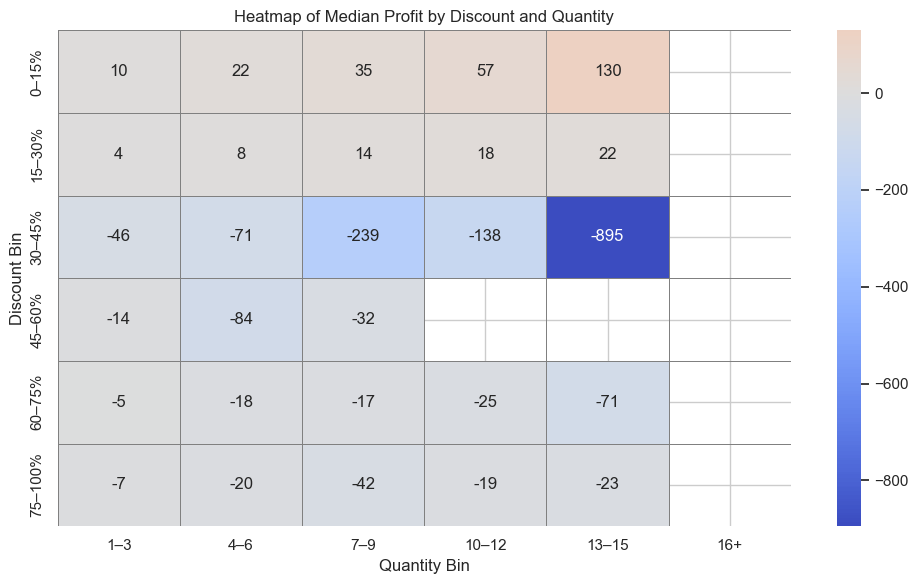

In [34]:
# Pastikan 'Discount' dalam skala 0–1 
if df['Discount'].max() > 1:
    df['Discount'] = df['Discount'] / 100

# Buat bin untuk Discount dan Quantity
discount_bins = [0, 0.15, 0.3, 0.45, 0.6, 0.75, 1.0]
discount_labels = ["0–15%", "15–30%", "30–45%", "45–60%", "60–75%", "75–100%"]

quantity_bins = [0, 3, 6, 9, 12, 15, 100]
quantity_labels = ["1–3", "4–6", "7–9", "10–12", "13–15", "16+"]

df['Discount_Bin'] = pd.cut(df['Discount'], bins=discount_bins, labels=discount_labels, include_lowest=True)
df['Quantity_Bin'] = pd.cut(df['Quantity'], bins=quantity_bins, labels=quantity_labels, include_lowest=True)

# Hitung median profit per kombinasi diskon dan kuantitas
heatmap_data = df.groupby(['Discount_Bin', 'Quantity_Bin'])['Profit'].median().unstack()

# Buat heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".0f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Heatmap of Median Profit by Discount and Quantity")
plt.xlabel("Quantity Bin")
plt.ylabel("Discount Bin")
plt.tight_layout()
plt.show()


### Heatmap of Median Profit by Discount and Quantity

Quantity Rendah + Diskon Tinggi = Penghancuran Margin

Kotak Quantity 1–3 dan 4–6 menunjukkan laba rata-rata negatif yang konsisten saat diskon melebihi 45%.

Ini merupakan transaksi berisiko tinggi yang menawarkan leverage minimal namun mengalami konsesi harga yang besar.

 **Volume Tidak Menjamin Keuntungan**

Bahkan dalam kotak 13–15 unit, laba rata-rata tetap negatif atau mendekati nol saat diskon melebihi 30–45%.

Menunjukkan harga yang tidak selaras atau struktur biaya yang tidak optimal, terutama dalam transaksi yang berorientasi pada SMB.

🟢 **Diskon 15–30% = Zona Keuntungan Stabil**

Di **hampir semua kotak Quantity**, rentang diskon ini menghasilkan **laba rata-rata positif**, yang menandakan rentang operasi yang aman bagi tim penetapan harga.

🧪 **Diskon Sangat Tinggi (60%–100%)**

**Beberapa kotak** dalam tingkatan ini **menunjukkan kerugian median yang tidak terlalu parah** — **mungkin disebabkan** oleh:

-Produk entri berbiaya rendah

-Kampanye uji coba

-Akuisisi CLTV

 Kesimpulan:
 Melarang atau mengontrol secara ketat transaksi dengan diskon ≤ 6 unit dan ≥ 45% — ini adalah yang paling merusak margin.

**Prioritaskan rentang diskon 15–30%** sebagai strategi yang stabil dan dapat diskalakan — terutama untuk kampanye yang didorong oleh volume.

**Review transaksi kuantitas tinggi (>13 unit) yang masih mengakibatkan kerugian margin** — ini tidak boleh dibiarkan beroperasi secara tidak menguntungkan secara default.

**Lacak dan pisahkan transaksi diskon 75–100% sebagai upaya promosi**, dan **tetapkan KPI** (misalnya, konversi, retensi) untuk mereka.

**Beralih ke kebijakan diskon dinamis yang mempertimbangkan kuantitas x margin**, bukan hanya ukuran transaksi atau potensi pendapatan.

## Region Based Profit Distribution by Customer Segment Scatterplot

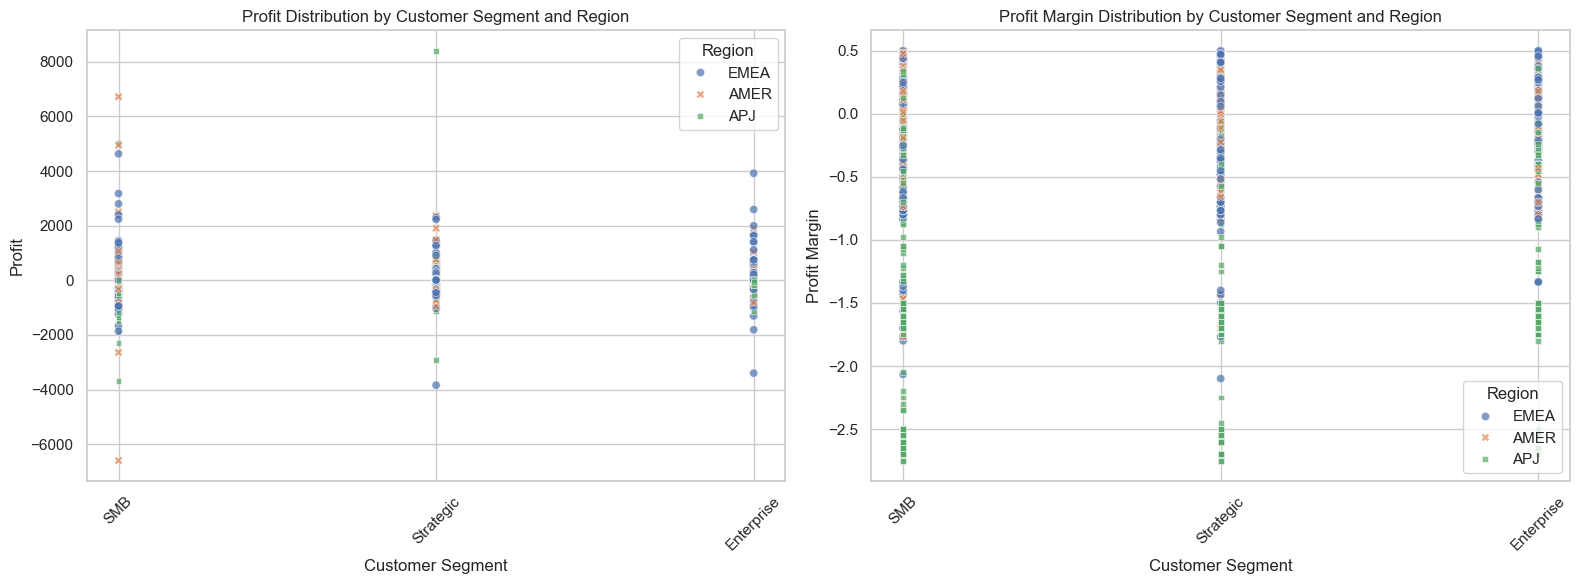

In [35]:
# Set visualization style
sns.set_style("whitegrid")

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# --- Plot 1: Profit Distribution by Segment and Region ---
sns.scatterplot(
    data=df,
    x="Segment",
    y="Profit",
    hue="Region",
    style="Region",
    alpha=0.7,
    ax=axes[0]
)
axes[0].set_title("Profit Distribution by Customer Segment and Region")
axes[0].set_xlabel("Customer Segment")
axes[0].set_ylabel("Profit")
axes[0].tick_params(axis='x', rotation=45)

# --- Plot 2: Profit Margin Distribution by Segment and Region ---
sns.scatterplot(
    data=df,
    x="Segment",
    y="Profit Margin",
    hue="Region",
    style="Region",
    alpha=0.7,
    ax=axes[1]
)
axes[1].set_title("Profit Margin Distribution by Customer Segment and Region")
axes[1].set_xlabel("Customer Segment")
axes[1].set_ylabel("Profit Margin")
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout and display
plt.tight_layout()
plt.show()


## Profit & Profit Margin Distribution by Region and Segment

### AMER

- **Semua segmen** (SMB, Strategic, Enterprise) secara konsisten menghasilkan **laba positif**.
- **beberapa outlier bernilai tinggi** (hingga $6K+).
- **Tingkat kerugian rendah** (~10–12%) mengonfirmasi pelaksanaan transaksi yang disiplin.
- Sebagian besar transaksi menghasilkan **margin yang sehat (10–40%)**.
- Spread margin luas, yang menunjukkan **kemenangan bernilai tinggi** dan **risiko diskon sesekali**.
- Segmen Strategic dan Enterprise memimpin dalam profitabilitas.

**AMER adalah Region paling seimbang dan menguntungkan — bernilai tinggi, bervolume tinggi, dan margin terlindungi.**

---

### EMEA

- Tampak sedikit lebih konservatif daripada AMER — **kelompok yang lebih ketat, **keuntungan sedang**.
- **Sebagian besar transaksi** tetap berada dalam **rentang keuntungan yang aman**, dengan sedikit kerugian besar.
- Margin stabil dan terpusat antara **0%–30%** di semua segmen.
- Volatilitas lebih rendah daripada AMER — cerminan dari **disiplin penetapan harga** atau **ukuran transaksi yang lebih kecil**.
**EMEA adalah wilayah berisiko rendah dan pengembalian sedang — dasar yang bagus untuk konsistensi operasional.**

---

### APJ:

- **Kepadatan tinggi** dari **transaksi yang merugi**, terutama di **SMB dan Strategic**.
- **Beberapa outlier negatif ekstrem** (–$2K hingga –$4K), kemungkinan didorong oleh harga yang buruk atau struktur biaya yang tinggi.
- **Mayoritas** transaksi **jatuh di bawah titik impas**, dengan banyak margin di bawah –100%, yang menunjukkan jenis transaksi yang cacat secara struktural atau pola diskon besar.
- **Margin median rendah di semua segmen, tidak hanya didorong oleh outlier**.
- **Margin negatif** secara konsisten mendominasi di **UKM dan Strategis**.
**APJ adalah wilayah yang paling tidak stabil secara finansial**. Intervensi diperlukan pada kebijakan harga dan penyesuaian biaya — terutama di UKM.


| **AMER** | Kuat | Sehat | Pertahankan dan replikasi model |

| **EMEA** | Sedang | Konsisten | Gunakan sebagai kontrol/dasar|

| **APJ** | Lemah | Tidak stabil | Restrukturisasi strategi penetapan harga|


## Median Discount by CLTV Group

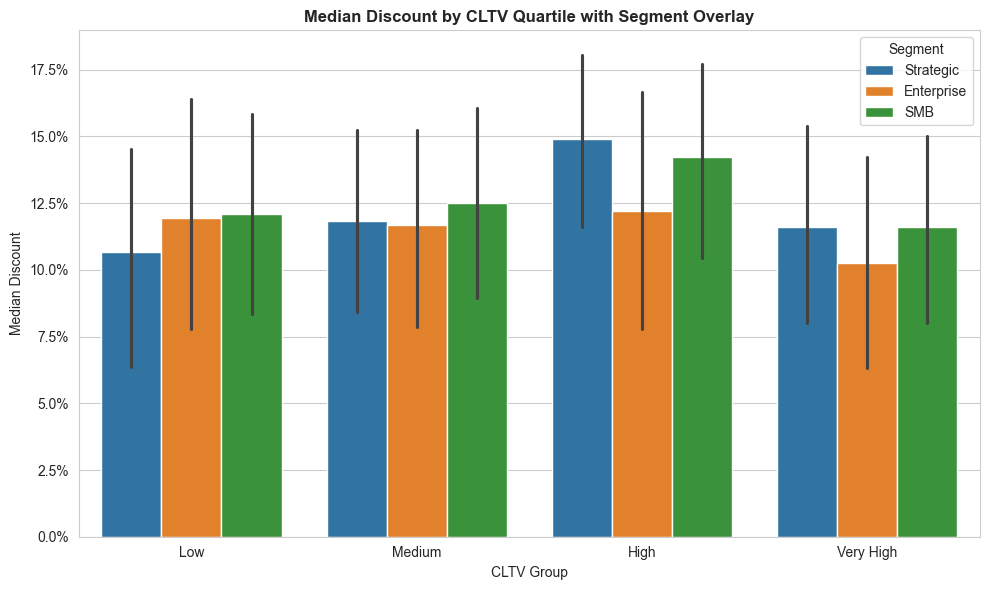

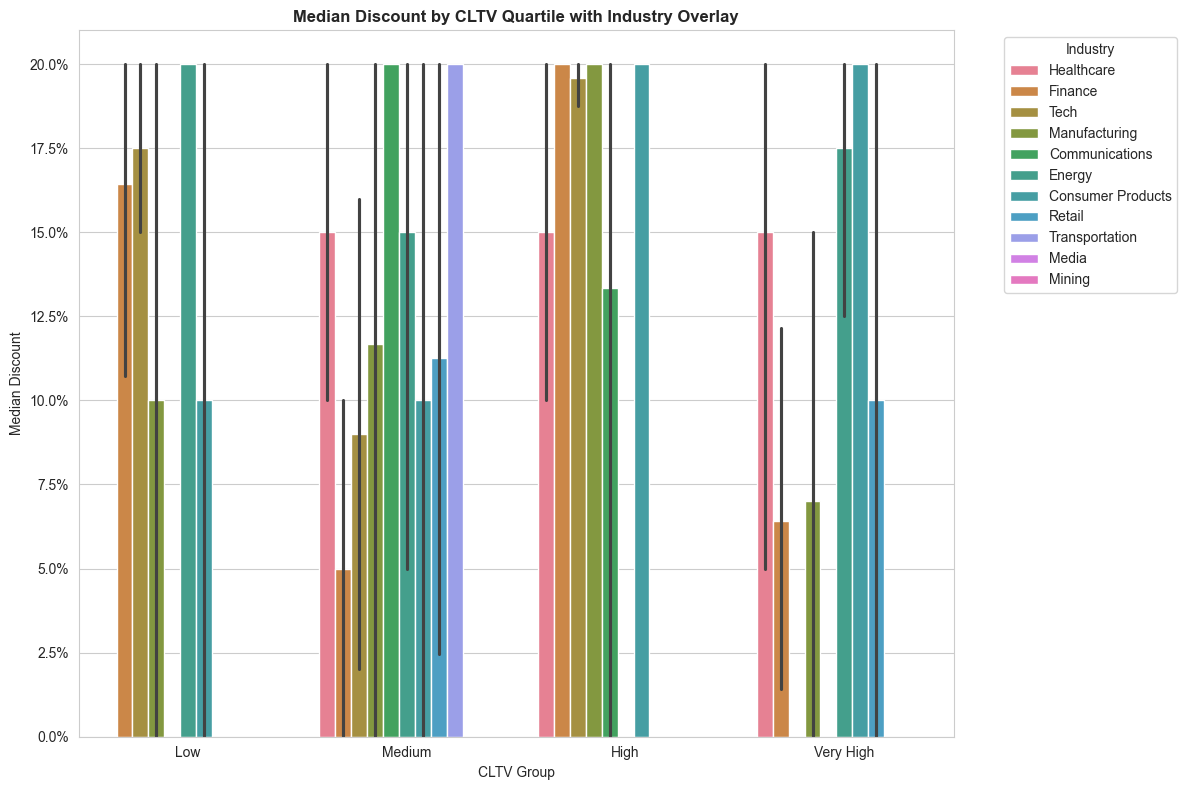

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Step 1: Prepare CLTV and median discount per customer 
cltv_df = df.groupby('Customer ID', as_index=False).agg({
    'Sales': 'sum',
    'Discount': 'median'
}).rename(columns={'Sales': 'CLTV', 'Discount': 'Median Discount'})

# Step 2: Create CLTV quartiles
cltv_df['CLTV Quartile'] = pd.qcut(cltv_df['CLTV'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Step 3: Merge with Segment and Industry
segment_info = df[['Customer ID', 'Segment']].drop_duplicates()
industry_info = df[['Customer ID', 'Industry']].drop_duplicates()

cltv_segment_df = pd.merge(cltv_df, segment_info, on='Customer ID', how='left')
cltv_industry_df = pd.merge(cltv_df, industry_info, on='Customer ID', how='left')

sns.set_style("whitegrid")

# 🎯 Plot 1: Segment Overlay
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cltv_segment_df,
    x='CLTV Quartile',
    y='Median Discount',
    hue='Segment',
    order=['Low', 'Medium', 'High', 'Very High']
)
plt.title("Median Discount by CLTV Quartile with Segment Overlay", fontsize=12, weight='bold')
plt.xlabel("CLTV Group")
plt.ylabel("Median Discount")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(title='Segment')
plt.tight_layout()
plt.show()

#  Plot 2: Industry Overlay
plt.figure(figsize=(12, 8))
sns.barplot(
    data=cltv_industry_df,
    x='CLTV Quartile',
    y='Median Discount',
    hue='Industry',
    order=['Low', 'Medium', 'High', 'Very High']
)
plt.title("Median Discount by CLTV Quartile with Industry Overlay", fontsize=12, weight='bold')
plt.xlabel("CLTV Group")
plt.ylabel("Median Discount")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Konsistensi Diskon di Seluruh Tingkat CLTV:

Segmen Strategis cenderung memiliki diskon rata-rata yang lebih tinggi dalam kelompok CLTV Tinggi (~15%).

Semua segmen menunjukkan diskon yang relatif konsisten di seluruh kuartil, yang menunjukkan strategi diskon tidak berkorelasi erat dengan CLTV — yang **dapat menjadi peluang untuk mengoptimalkan**.

Pelanggan SMB menerima diskon yang sedikit lebih tinggi atau serupa dibandingkan dengan Enterprise di sebagian besar kuartil.

Pelanggan strategis mendapatkan diskon rata-rata tertinggi dalam kelompok CLTV Tinggi, yang dapat menunjukkan penawaran khusus untuk akun berpotensi tinggi.

Menariknya, diskon rata-rata sedikit menurun dalam kelompok ini, terutama untuk Enterprise, yang menunjukkan kemungkinan harga yang lebih berbasis nilai untuk pelanggan CLTV tinggi.




Industri memiliki varians tinggi, dengan banyak industri mencapai atau melebihi diskon 20% dalam kelompok CLTV tertentu (misalnya, Teknologi, Keuangan, Produk Konsumen).

Beberapa industri secara konsisten memiliki diskon tinggi terlepas dari kelompok CLTV, yang dapat menjadi tanda bahaya untuk kebocoran margin atau harga yang tidak selaras.

Teknologi, Keuangan, dan Energi: Sektor-sektor ini menunjukkan diskon tinggi bahkan dalam kuartil CLTV Rendah, yang menunjukkan kemungkinan diskon berlebih.

Perlu memperketat batasan diskon atau memperkenalkan kebijakan diskon berjenjang berdasarkan nilai dan potensi transaksi.

Ritel dan Pertambangan: Industri-industri ini cenderung memiliki diskon yang lebih rendah dan lebih stabil, mungkin mencerminkan harga berbasis komoditas atau tingkat kustomisasi yang rendah.

## Avg Discount and Total Sales vs Profit Margin per Quarter

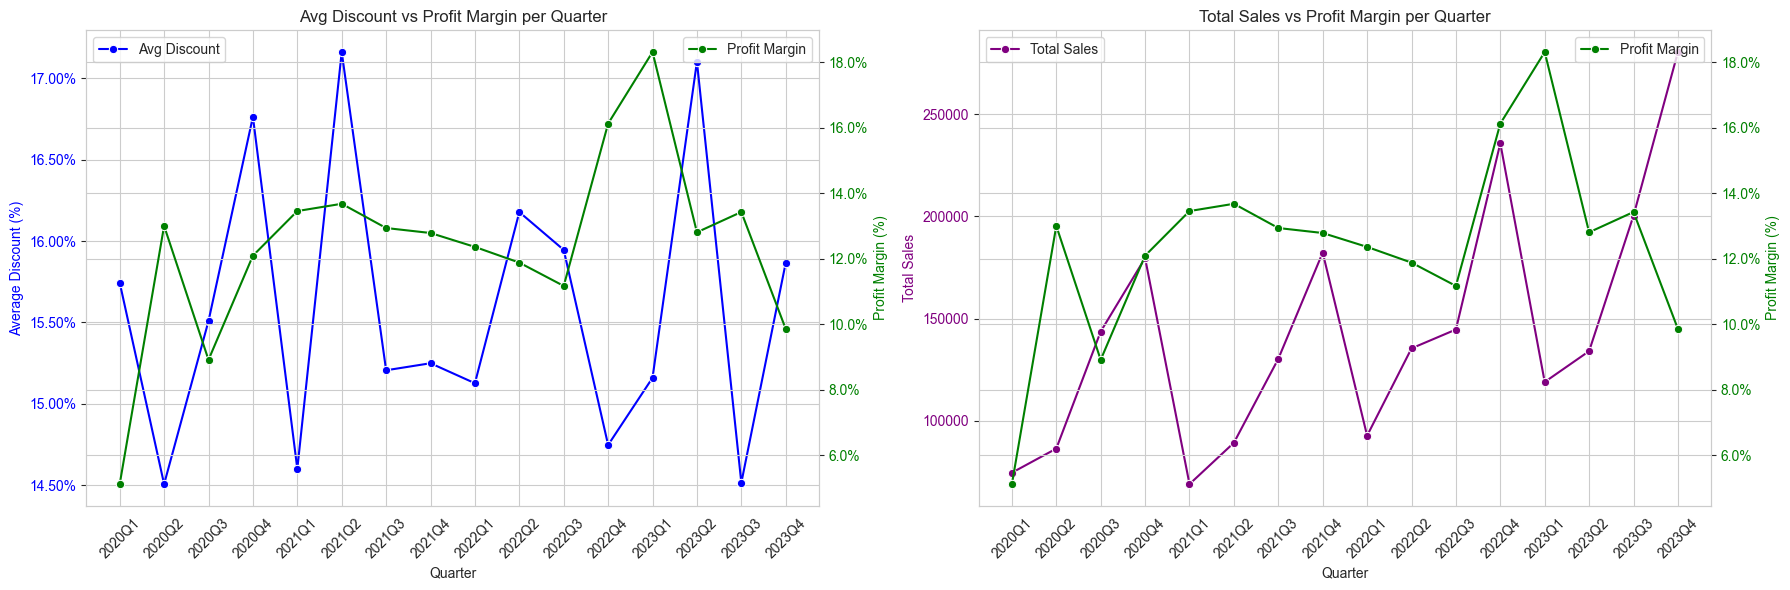

In [5]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Profit Margin'] = df['Profit'] / df['Sales']
df['Year-Quarter'] = df['Order Date'].dt.to_period('Q').astype(str)

quarterly_trends = df.groupby('Year-Quarter').agg({
    'Discount': 'mean',
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()

quarterly_trends['Profit Margin'] = quarterly_trends['Profit'] / quarterly_trends['Sales']
quarterly_trends = quarterly_trends.rename(columns={
    'Discount': 'Avg Discount',
    'Sales': 'Total Sales'
})

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

color1, color2 = 'blue', 'green'
sns.lineplot(data=quarterly_trends, x='Year-Quarter', y='Avg Discount', marker='o', ax=ax1, label='Avg Discount', color=color1)
ax1.set_ylabel('Average Discount (%)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.set_xlabel('Quarter')
ax1.set_title('Avg Discount vs Profit Margin per Quarter')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

ax2 = ax1.twinx()
sns.lineplot(data=quarterly_trends, x='Year-Quarter', y='Profit Margin', marker='o', ax=ax2, label='Profit Margin', color=color2)
ax2.set_ylabel('Profit Margin (%)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

color3 = 'purple'
sns.lineplot(data=quarterly_trends, x='Year-Quarter', y='Total Sales', marker='o', ax=ax3, label='Total Sales', color=color3)
ax3.set_ylabel('Total Sales', color=color3)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.set_xlabel('Quarter')
ax3.set_title('Total Sales vs Profit Margin per Quarter')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True)

ax4 = ax3.twinx()
sns.lineplot(data=quarterly_trends, x='Year-Quarter', y='Profit Margin', marker='o', ax=ax4, label='Profit Margin', color=color2)
ax4.set_ylabel('Profit Margin (%)', color=color2)
ax4.tick_params(axis='y', labelcolor=color2)
ax4.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()


## Quarterly Discount, Sales, and Profit Margin Trends

####  Temuan Utama:
- **Tren terbalik terlihat**: Saat diskon rata-rata meningkat, margin laba sering menurun — mencerminkan **erosi margin** dari diskon agresif.
- Kuartal tertentu menunjukkan **margin laba yang stabil atau membaik** meskipun diskon meningkat, yang menunjukkan **diskon strategis** atau **volume transaksi yang lebih tinggi**.
- Margin laba meningkat di beberapa kuartal bahkan saat diskon tetap stabil, yang menunjukkan **efisiensi operasional** lainnya atau **penjualan berkualitas lebih tinggi**.
- **Puncak penjualan** tidak selalu berkorelasi dengan margin laba yang tinggi.
- **Kuartal volume tinggi** yang juga menunjukkan **peningkatan margin** menandakan diskon yang dioptimalkan dan/atau campuran transaksi yang menguntungkan.
- Penurunan penjualan dan margin menunjukkan **kemerosotan musiman**, **inefisiensi penjualan**, atau kampanye diskon yang tidak efektif.

Action yang harus dilakukan:
- **Pantau titik kritis quarter**: Gunakan tren ini untuk menentukan **treshold diskon** yang dapat menyebabkan kerugian bagi profitabilitas.

## Waterfall Chart: Discount Impact on Profit

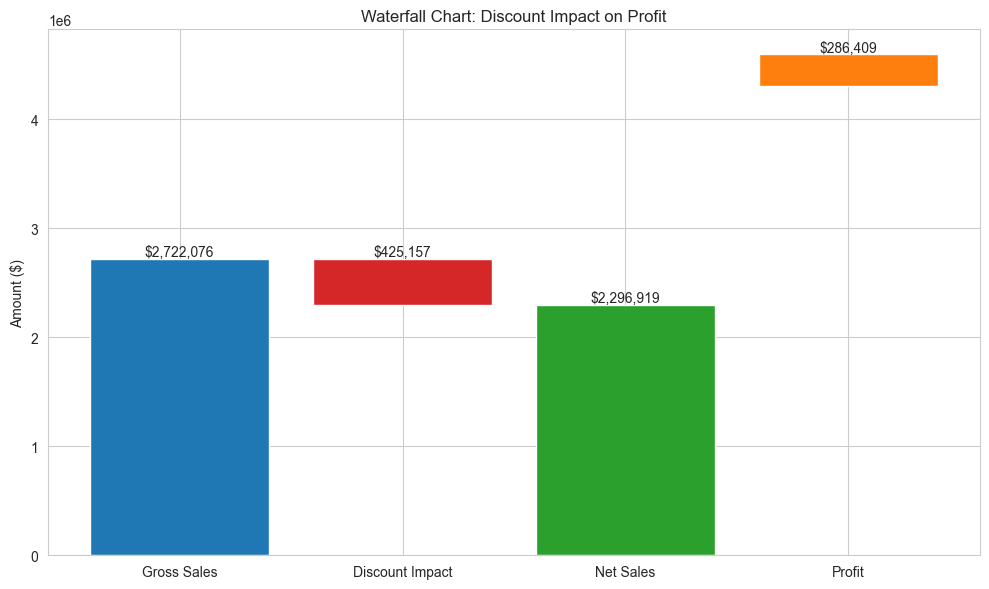

In [6]:
# STEP 1: Calculate necessary financials
gross_sales_total = df['Sales'].sum() / (1 - df['Discount'].mean())
discount_impact_total = gross_sales_total - df['Sales'].sum()
net_sales_total = df['Sales'].sum()
profit_total = df['Profit'].sum()

# STEP 2: Define values and steps
steps = ['Gross Sales', 'Discount Impact', 'Net Sales', 'Profit']
values = [
    gross_sales_total,
    -discount_impact_total,  # shown as negative
    net_sales_total,
    profit_total
]

# STEP 3: Calculate base positions for correct stacking
base = [0]
for i in range(1, len(values)):
    base.append(base[-1] + values[i - 1])

# STEP 4: Plot the waterfall chart
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#1f77b4', '#d62728', '#2ca02c', '#ff7f0e']

for i in range(len(values)):
    bottom = 0 if i == 0 else base[i] if values[i] < 0 else base[i] - values[i]
    ax.bar(steps[i], values[i], bottom=bottom, color=colors[i])

    # Add text labels
    ax.text(i, bottom + values[i] if values[i] > 0 else bottom, 
            f"${abs(values[i]):,.0f}", ha='center', va='bottom', fontsize=10)

# STEP 5: Style the chart
ax.set_title('Waterfall Chart: Discount Impact on Profit')
ax.set_ylabel('Amount ($)')
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()


Gross Sales ($2,722,076) – Bar Biru
Ini adalah total penjualan tanpa memperhitungkan diskon.

Mewakili nilai maksimum yang bisa diperoleh jika tidak ada diskon yang diberikan.

Bar ini adalah baseline dari seluruh analisis.

2. Discount Impact (–$425,157) – Bar Merah
Menunjukkan jumlah nilai diskon yang diberikan dari Gross Sales.

Nilai ini bersifat negatif, karena mengurangi potensi pendapatan.

Diskon sebesar $425,157 telah "menggerus" hampir 15.6% dari gross sales, yang sangat signifikan.

3. Net Sales ($2,296,919) – Bar Hijau
Ini adalah hasil dari:

Gross Sales – Discount Impact=Net Sales
Merupakan jumlah penjualan yang benar-benar diterima oleh perusahaan setelah diskon.

4. Profit ($286,409) – Bar Oranye
Ini adalah laba bersih setelah dikurangi semua biaya operasional, dll.

Merupakan pendapatan bersih yang benar-benar masuk ke perusahaan dari seluruh aktivitas penjualan setelah diskon.

🟢 (5–10%) Bucket
Avg & median margins both above 15%

Conclusion: **Very stable — could be a safe default range for tighter controls.**

🟡 (10–15%) Bucket
Avg margin: ~3.4%

Median barely positive

Conclusion: **May be borderline viable, but unstable — proceed with caution.**

🔹 (15–20%) Discount Bucket
Most frequent (3,657 transactions).

Highest average margin: 17.7%

Median also strong: 17.5%

Conclusion: **This is likely the ideal discount range — high usage and strong profit.**

🔸 (25–30%) Discount Bucket
Avg margin: -11.6%

Median margin: -8.6%

Conclusion: **Most transactions in this band are unprofitable.**

🔺 (30–35%) Discount Bucket
Avg margin: -17.4%

No positive margins at all

Conclusion: **Discounting at this level is highly risky and often leads to losses.**

-------------------------------------------------------------------------------------------------------------------------------------------------------
**Discount %	Interpretation	Action**

0–10%	Modest / Value-driven	Encourage

0–20%	Strategic / Situational	Monitor

20–30%	Aggressive	Justify case-by-case

30%	Risky / Unsustainable	Restrict or review

## Profit Margin (%) Heatmap by Segment and Industry

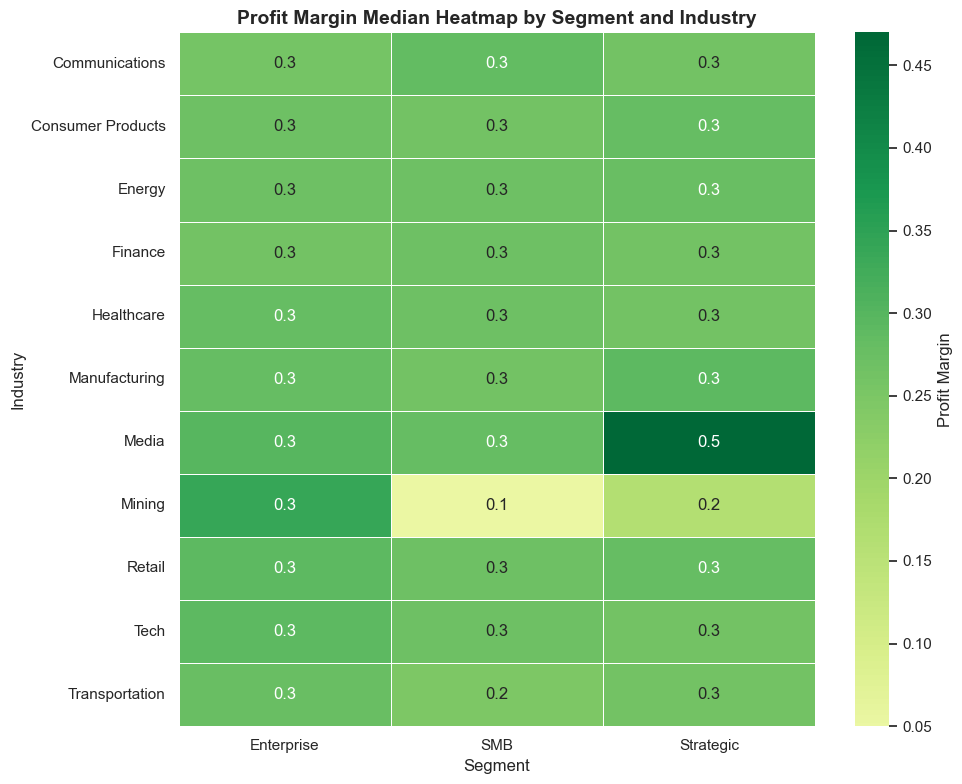

In [8]:
# Group by Segment and Industry
combined_policy = df.groupby(['Segment', 'Industry'], as_index=False).agg(
    Profit_Margin=('Profit Margin', 'median')
)

# Pivot the table to shape it for heatmap
heatmap_data = combined_policy.pivot(index='Industry', columns='Segment', values='Profit_Margin')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    center=0,
    linewidths=.5,
    linecolor='white',
    cbar_kws={'label': 'Profit Margin'}
)

plt.title("Profit Margin Median Heatmap by Segment and Industry", fontsize=14, weight='bold')
plt.xlabel("Segment")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


## Segment-Industry Discount Policy 

1. Cap at 10–12% (High Risk)
2. Cap at 12–15% (Moderate Risk)
3. Allows up to 15% (Stable)
4. Allow up to 20–25% (Strong CLTV & Margin)

Enterprise Communications (1)

Enterprise Consumer Products (3)

Enterprise Energy (3)

Enterprise Finance (3)

Enterprise Healthcare (3)

Enterprise Manufacturing (3)
 
Enterprise Media (3)

Enterprise Mining (3)
 
Enterprise Retail (3)

Enterprise Tech (3)

Enterprise Transportation (1)

SMB Communications (3)

SMB Consumer Products (2)

SMB Energy (3)

SMB Finance (3)

SMB Healthcare (3)

SMB Manufacturing (3)

SMB Media (2)

SMB Mining (3)

SMB Retail (1)

SMB Tech (2)

SMB Transportation (3)

Strategic Communications (2)

Strategic Consumer Products (3)

Strategic Energy (3)

Strategic Finance (3)

Strategic Healthcare (2)

Strategic Manufacturing (3)

Strategic Media (3)

Strategic Mining (4)
 
Strategic Retail (3)

Strategic Tech (3)

Strategic Transportation (2)

## Profit Margin Heatmap by Segment × CLTV × Deal Size

C:\Users\asus\AppData\Local\Temp\ipykernel_12004\2687313216.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = deal_policy.pivot_table(


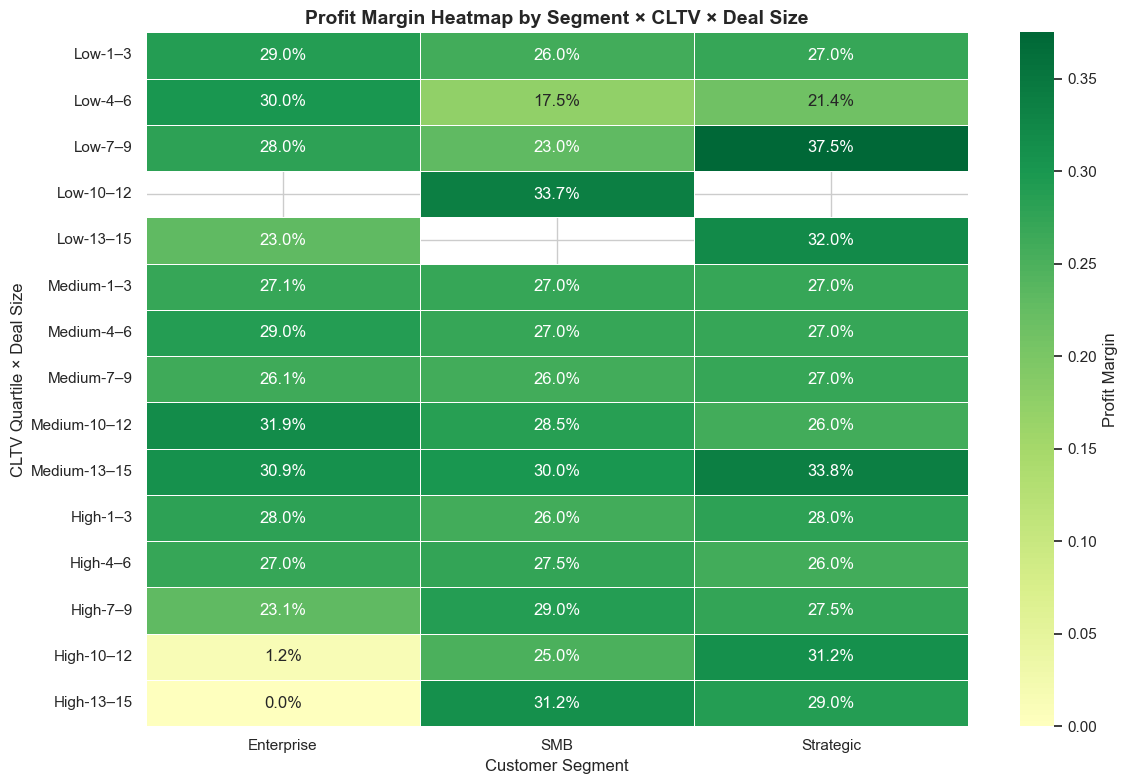

In [26]:
# Hitung CLTV
df['CLTV'] = df.groupby('Customer ID')['Sales'].transform('sum')

# Pastikan nilai max CLTV cukup tinggi agar bins valid
max_cltv = max(60000, df['CLTV'].max())

# Binning CLTV
df['CLTV Quartile'] = pd.cut(
    df['CLTV'], 
    bins=[0, 10000, 30000, 60000, max_cltv + 1],
    labels=['Low', 'Medium', 'High', 'Very High'],
    include_lowest=True
)

quantity_bins = [0, 3, 6, 9, 12, 15, 100]
quantity_labels = ["1–3", "4–6", "7–9", "10–12", "13–15", "16+"]
df['Quantity_Bin'] = pd.cut(df['Quantity'], bins=quantity_bins, labels=quantity_labels, include_lowest=True)

# Group and aggregate
deal_policy = df.groupby(['Segment', 'CLTV Quartile', 'Quantity_Bin'], observed=True, as_index=False).agg(
    Profit_Margin=('Profit Margin', 'median')
)

# Pivot for heatmap
pivot_table = deal_policy.pivot_table(
    index=["CLTV Quartile", "Quantity_Bin"],
    columns="Segment",
    values="Profit_Margin"
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.heatmap(
    pivot_table,
    annot=True,
    fmt=".1%",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Profit Margin'}
)

plt.title("Profit Margin Heatmap by Segment × CLTV × Deal Size", fontsize=14, weight='bold')
plt.xlabel("Customer Segment")
plt.ylabel("CLTV Quartile × Deal Size")
plt.tight_layout()
plt.show()


## Segment × CLTV × Deal Size Discount Policy
1. Cap at 10–12% (High Risk)
2. Cap at 12–15% (Moderate Risk)
3. Cap at 15% (Stable)
4. Allow up to 20–25% (Strong CLTV & Margin)

Enterprise low (1-3) Allows up to 15% (Stable)

Enterprise low (4-6) Allows up to 15% (Stable)

Enterprise low (7-9) Allows up to 15% (Stable)

Enterprise low (10-12) Allows up to 15% (Stable)

Enterprise low (13-15) Cap at 12–15% (Moderate Risk)

Enterprise Medium (1-3) Allows up to 15% (Stable)
 
Enterprise Medium (4-6) Allows up to 15% (Stable)

Enterprise Medium (7-9) Allows up to 15% (Stable)

Enterprise Medium (10-12) Allows up to 15% (Stable)

Enterprise Medium (13-15) Allows up to 15% (Stable)

Enterprise High (1-3) Allows up to 15% (Stable)

Enterprise High (4-6) Allows up to 15% (Stable)

Enterprise High (7-9) Allows up to 15% (Stable)

Enterprise High (10-12) Allows up to 15% (Stable)
 
Enterprise High (13-15) Allows up to 15% (Stable)

Enterprise Very High (1-3) Allows up to 15% (Stable)

Enterprise Very High (4-6) Allows up to 15% (Stable)

Enterprise Very High (7-9) Cap at 12–15% (Moderate Risk)

Enterprise Very High (10-12) Cap at 10–12% (High Risk)

Enterprise Very High (13-15) Cap at 10–12% (High Risk)

SMB low (1-3) Allows up to 15% (Stable)

SMB low (4-6) Allows up to 15% (Stable)

SMB low (7-9) Allows up to 15% (Stable)

SMB low (10-12) Allows up to 15% (Stable)

SMB low (13-15) Cap at 12–15% (Moderate Risk)

SMB Medium (1-3) Allows up to 15% (Stable)
 
SMB Medium (4-6) Allows up to 15% (Stable)

SMB Medium (7-9) Allows up to 15% (Stable)

SMB Medium (10-12) Allows up to 15% (Stable)

SMB Medium (13-15) Allows up to 15% (Stable)

SMB High (1-3) Allows up to 15% (Stable)

SMB High (4-6) Allows up to 15% (Stable)

SMB High (7-9) Allows up to 15% (Stable)

SMB High (10-12) Cap at 12–15% (Moderate Risk)

SMB High (13-15) Allows up to 15% (Stable)

SMB Very High (1-3) Allows up to 15% (Stable)

SMB Very High (4-6) Allows up to 15% (Stable)

SMB Very High (7-9) Allows up to 15% (Stable)

SMB Very High (10-12) Allows up to 15% (Stable)

SMB Very High (13-15) Allows up to 15% (Stable)

Strategic low (1-3) Allows up to 15% (Stable)

Strategic low (4-6) Allows up to 15% (Stable)

Strategic low (7-9) Allows up to 15% (Stable)

Strategic low (10-12) Cap at 12–15% (Moderate Risk)

Strategic low (13-15) Allows up to 15% (Stable)

Strategic Medium (1-3) Allows up to 15% (Stable)

Strategic Medium (4-6) Allows up to 15% (Stable)

Strategic Medium (7-9) Allows up to 15% (Stable)

Strategic Medium (10-12) Allows up to 15% (Stable) 

Strategic Medium (13-15) Cap at 10–12% (High Risk)
 
Strategic High (1-3) Allows up to 15% (Stable)

Strategic High (4-6) Allows up to 15% (Stable)
 
Strategic High (7-9) Allows up to 15% (Stable)

Strategic High (10-12) Allows up to 15% (Stable)

Strategic high (13-15) Allows up to 15% (Stable)

Strategic Very High (1-3) Allows up to 15% (Stable)
 
Strategic Very High (4-6) Allows up to 15% (Stable)

Strategic Very High (7-9) Allows up to 15% (Stable)

Strategic Very High (10-12) Allows up to 15% (Stable)

Strategic high (13-15) Allows up to 15% (Stable)
